# Brain Tumor Classification via Convolutional and Capsule networks.

#### Machine Learning Final Project.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import skimage
from skimage import img_as_float
from skimage.exposure import equalize_hist
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from skimage.measure import block_reduce
from sklearn.utils import shuffle
import pandas as pd
from os import listdir

from tqdm import tqdm_notebook

import h5py

/home/use/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pd.options.mode.chained_assignment = None

# Load Data:

In [3]:
def read_h5py_folder(path, indicies=(0,10)):
    columns = ['label', 'PID', 'image', 'tumorBorder', 'tumorMask']
    tmp_df = pd.DataFrame(data = np.zeros((indicies[1]-indicies[0], len(columns))), columns=columns, dtype=np.object)
    files = listdir(path)

    for i, each_file in enumerate(files[indicies[0]:indicies[1]]):
        if each_file[-3:]=='mat':
            data = h5py.File(path + '/' + each_file)['cjdata']
            tmp_df['label'][i] = data['label'][0][0]
            tmp_df['PID'][i] = data['PID'][0][0]
            tmp_df['image'][i] = img_as_float(data['image'][:])
            tmp_df['tumorBorder'][i] = data['tumorBorder'][0]
            tmp_df['tumorMask'][i] = img_as_float(data['tumorMask'][:])
        else:
            print('not .mat file dropped')
            tmp_df['label'][i], tmp_df['PID'][i], tmp_df['image'][i] = np.NaN, np.NaN, np.NaN
            tmp_df['tumorBorder'][i], tmp_df['tumorMask'][i] = np.NaN, np.NaN
    tmp_df.dropna(axis=0, inplace=True)
    tmp_df.reset_index(inplace=True)
    return tmp_df

In [4]:
#load data from several folders
data=read_h5py_folder(path='data/brainTumorDataPublic_1766', indicies=(0,766))
data1=read_h5py_folder(path='data/brainTumorDataPublic_7671532', indicies=(0,766))
data2=read_h5py_folder(path='data/brainTumorDataPublic_15332298', indicies=(0,766))
data3=read_h5py_folder(path='data/brainTumorDataPublic_22993064', indicies=(0,766))

In [5]:
data = pd.concat([data,data1,data2,data3],axis=0,ignore_index=True) #merge into one dataframe
del data1,data2,data3
data.label.value_counts()

2.0    1426
3.0     930
1.0     708
Name: label, dtype: int64

###### Check data:

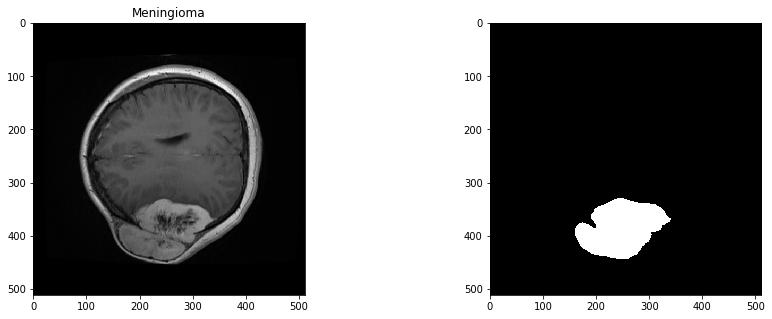

In [6]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(data['image'][4], cmap='gray')
ax[0].set_title('Meningioma')
ax[1].imshow(data['tumorMask'][4], cmap='gray');

In [7]:
def get_tumor_border(img, border):
    border_img = np.zeros_like(img)
    border_ = np.array(border, dtype=np.int16)
    border_array = border_.reshape(border_.shape[0]//2,2)
    for each_idx_pair in border_array:
        border_img[each_idx_pair[0], each_idx_pair[1]] = 1.
    return img_as_float(border_img)

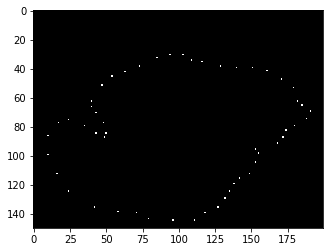

In [8]:
idx = 4
border = get_tumor_border(img = data['image'][idx], border=data['tumorBorder'][idx])
plt.imshow(border[300:450,150:350],cmap='gray');

# Preprocessing:

 - ###### Augmentation:

In [9]:
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def augment(image, mask, flip_p1=0.7, flip_p2=0.7, factor=2):
    
    img_mask = np.stack([image, mask], axis=2)
    
    def elastic_transform(image, alpha, sigma, alpha_affine):
    
        random_state = np.random.RandomState(None)
        shape = image.shape
        shape_size = shape[:2]

        center_square = np.float32(shape_size) // 2
        square_size = min(shape_size) // 3
        pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
        pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
        M = cv2.getAffineTransform(pts1, pts2)
        image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dz = np.zeros_like(dx)

        x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

        return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
    
    transformed = elastic_transform(img_mask, img_mask.shape[1] * factor, 0.08*img_mask.shape[1], 0.08*img_mask.shape[1])
    
    if np.random.rand() < flip_p1:
        transformed = np.flip(transformed, axis=0).copy()
    
    if np.random.rand() < flip_p2:
        transformed = np.flip(transformed, axis=1).copy()
    
    out_img = transformed[...,0].copy()
    out_mask = transformed[...,1].copy()
        
    return img_as_float(out_img), img_as_float(out_mask)

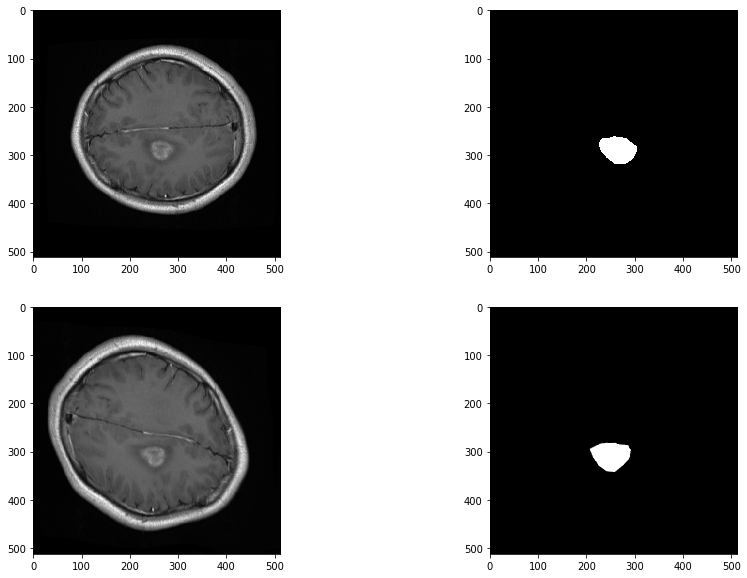

In [10]:
img = data['image'][0]
mask = data['tumorMask'][0]
augi, augm = augment(img, mask, factor=4)

fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].imshow(img, cmap='gray')
ax[0,1].imshow(mask, cmap='gray')
ax[1,0].imshow(augi, cmap='gray')
ax[1,1].imshow(augm, cmap='gray');

 - ###### Histogram equalization:

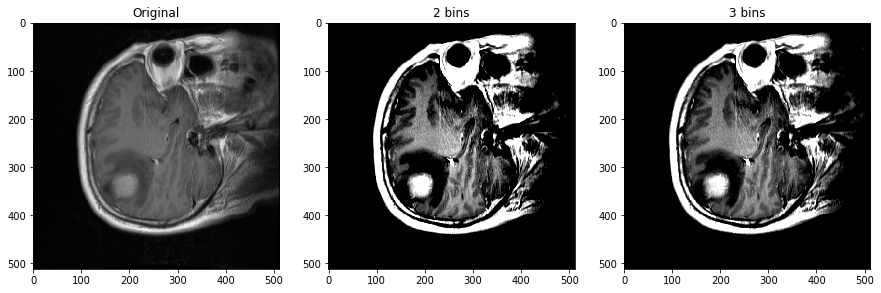

In [11]:
idx = 1
img = data['image'][idx]
mask = data['tumorMask'][idx]
fig, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(equalize_hist(img, nbins=2,mask=mask), cmap='gray')
ax[2].imshow(equalize_hist(img, nbins=3, mask=mask), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('2 bins')
ax[2].set_title('3 bins');

 - ###### Prepare data and split into test / train:

In [12]:
def resize_fast(X, size=256):
    X['shape_'] = X['image'].apply(lambda x: x.shape[0])
    mean_size = X['shape_'].mean()
    bad_obs_idx = X[X.shape_ <= mean_size].index.tolist()
    bad_obs = X.iloc[bad_obs_idx,:].drop('shape_', axis=1).reset_index(drop=True).copy()
    good_obs = X.drop(bad_obs_idx, axis=0).drop('shape_', axis=1).reset_index(drop=True).copy()

    while not good_obs.image[0].shape[0] <= size:
        good_obs.image= good_obs.image.apply(lambda x: block_reduce(x, (2,2), func=np.max))
        good_obs.tumorMask= good_obs.tumorMask.apply(lambda x: block_reduce(x, (2,2), func=np.max))
    
    while not bad_obs.image[0].shape[0] <= size:
        bad_obs.image= bad_obs.image.apply(lambda x: block_reduce(x, (2,2), func=np.max))
        bad_obs.tumorMask= bad_obs.tumorMask.apply(lambda x: block_reduce(x, (2,2), func=np.max))
        
    out = pd.concat([good_obs,bad_obs],axis=0,ignore_index=True)
    out.reset_index(inplace=True)
    return out

In [13]:
def get_train_test_data(X ,ratio):
    df = shuffle(X.copy()).reset_index(drop=True)
    train_idx = int(np.round(df.shape[0]*ratio))
    train_df = df[train_idx:]
    test_df = df[:train_idx]
    train_df.reset_index(inplace=True, drop = True)
    test_df.reset_index(inplace=True, drop = True)
    try:
        return train_df.drop('index', axis=1), test_df.drop('index', axis=1)
    except:
        return train_df, test_df

In [14]:
data = resize_fast(data, 128)

In [15]:
X_train, X_test = get_train_test_data(data, 0.2)

 - ###### Wrap the data into PyTorch class and feed DataLoader:

In [16]:
class tumor_data(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        
        if dataframe.image[0].ndim==2:
            images = dataframe.image.apply(lambda x: x.reshape(1, x.shape[0], x.shape[1]))
            
        self.images = images
        self.labels = dataframe.label.tolist()
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        img = torch.from_numpy(self.images[idx])
        target = torch.from_numpy(np.array([self.labels[idx]-1]))
        
        return img, target

In [17]:
train_data = tumor_data(X_train)
test_data = tumor_data(X_test)

In [18]:
batch_size, n_iters = 25, 700
n_epoches = int(n_iters / (len(train_data)/batch_size))
n_epoches

7

In [19]:
train_feeder = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_feeder = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=False)

# Vanilla CNN:

In [20]:
class vanilaCNN(nn.Module):
    def __init__(self):
        super(vanilaCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2)
        
        #256 - 32*61*61
        #128 - 64, 29, 29
        
        #self.lin1 = nn.Linear(64*61*61, 800) #256
        self.lin1 = nn.Linear(64*29*29, 800) #128
        self.fc1 = nn.ReLU()
        self.lin2 = nn.Linear(800, 800)
        self.fc2 = nn.ReLU()
        self.lin3 = nn.Linear(800, 3)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        #print(out.size())
        out = self.lin1(out.view(out.size(0),-1))
        out = self.fc1(out)
        out = self.lin2(out)
        out = self.fc2(out)
        out = self.lin3(out)
        out = self.sigmoid(out)
        return out

In [21]:
vanila_model=vanilaCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vanila_model.parameters(), lr=1e-5)

 - ##### Train:

In [22]:
history = list()

for epoch in tqdm_notebook(range(n_epoches)):
    for i,(image, label) in enumerate(train_feeder):
        inputs = Variable(image.cuda()).float()
        labels = Variable(label.cuda())
        
        optimizer.zero_grad()
        outputs = vanila_model(inputs)
        
        loss = criterion(outputs, labels.long().view(-1))
        
        loss.backward()
        optimizer.step()
        history.append(loss.cpu().data.numpy())

A Jupyter Widget

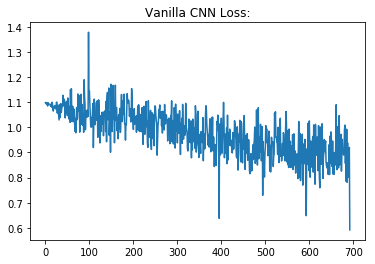

In [23]:
plt.title('Vanilla CNN Loss:')
plt.plot(history);

 - ##### Test:

In [24]:
correct, y_pred, y_true = 0, list(), list()

for image, labels in tqdm_notebook(test_feeder):
    
    inputs = Variable(image.cuda()).float()
    outputs = vanila_model(inputs)
    
    pred = np.argmax(outputs.data.cpu().numpy())
    true = labels.numpy()[0][0]
    correct += int(pred == true)
    y_pred.append(pred)
    y_true.append(true)

A Jupyter Widget

 - ##### Accuracy:

In [25]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
print('Accuracy:', correct/len(test_data))

Accuracy: 0.6769983686786297


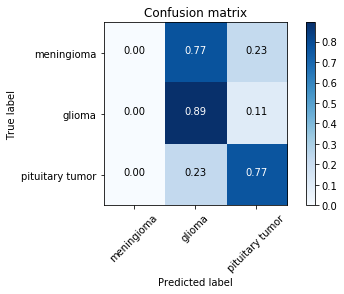

In [27]:
plot_confusion_matrix(cm=confusion_matrix(y_true, y_pred), classes=['meningioma','glioma','pituitary tumor'])

# Vanilla CNN with histogram equalization:

 - ##### Prepare data:

In [28]:
def hist_equalize(X, bins=2):
    for i in range(X.shape[0]):
        X.image[i] = equalize_hist(X.image[i], nbins=bins, mask=X.tumorMask[i])
    return X

In [29]:
data_heq=hist_equalize(data)

In [30]:
X_train, X_test = get_train_test_data(data_heq, 0.2)

train_data = tumor_data(X_train)
test_data = tumor_data(X_test)

In [31]:
train_feeder = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_feeder = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=False)

 - ##### Train:

In [32]:
vanila_model=vanilaCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vanila_model.parameters(), lr=1e-5)

In [33]:
history = list()

for epoch in tqdm_notebook(range(n_epoches)):
    for i,(image, label) in enumerate(train_feeder):
        inputs = Variable(image.cuda()).float()
        labels = Variable(label.cuda())
        
        optimizer.zero_grad()
        outputs = vanila_model(inputs)
        
        loss = criterion(outputs, labels.long().view(-1))
        
        loss.backward()
        optimizer.step()
        history.append(loss.cpu().data.numpy())

A Jupyter Widget

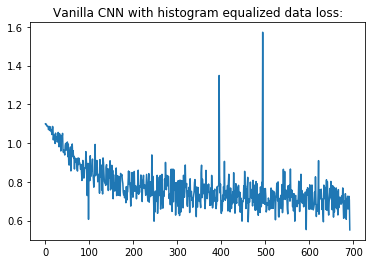

In [34]:
plt.title('Vanilla CNN with histogram equalized data loss:')
plt.plot(history);

 - ##### Test:

In [35]:
correct, y_pred, y_true = 0, list(), list()

for image, labels in tqdm_notebook(test_feeder):
    
    inputs = Variable(image.cuda()).float()
    outputs = vanila_model(inputs)
    
    pred = np.argmax(outputs.data.cpu().numpy())
    true = labels.numpy()[0][0]
    correct += int(pred == true)
    y_pred.append(pred)
    y_true.append(true)

A Jupyter Widget

 - ##### Accuracy:

In [36]:
print('Accuracy:', correct/len(test_data))

Accuracy: 0.8401305057096248


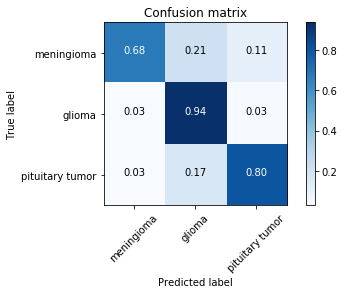

In [37]:
plot_confusion_matrix(cm=confusion_matrix(y_true, y_pred), classes=['meningioma','glioma','pituitary tumor'])

# Densenet:

$references$: https://arxiv.org/pdf/1608.06993.pdf

![title](denseblock.png)

![title](densenet.png)

 - ###### Define a model:

In [38]:
class basic_block(nn.Module):
    def __init__(self, in_channles, out_channels):
        super(basic_block, self).__init__()
        
        self.batch = nn.BatchNorm2d(in_channles)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channles, out_channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = self.batch(x)
        x = self.relu(x)
        x = self.conv(x)
        return x
    
class bottleneck_block(nn.Module):
    def __init__(self, in_channles, out_channels):
        super(bottleneck_block, self).__init__()
        
        self.batch = nn.BatchNorm2d(in_channles)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channles, out_channels, kernel_size=1, padding=0)
        
    def forward(self, x):
        x = self.batch(x)
        x = self.relu(x)
        x = self.conv(x)
        return x
    
class dense_block(nn.Module):
    def __init__(self, in_channles, out_channels):
        super(dense_block, self).__init__()
        
        self.block1 = basic_block(in_channles, out_channels)
        self.block2 = basic_block(out_channels, out_channels)
        self.block3 = basic_block(2*out_channels, 2*out_channels)
        self.block4 = bottleneck_block(4*out_channels, out_channels)
        
    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x1)
        cat1 = torch.cat((x1, x2), 1)
        x3 = self.block3(cat1)
        cat2 = torch.cat((x1,x2,x3),1)
        x4 = self.block4(cat2)
        return x4
        
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        
        self.dense1 = dense_block(1, 64)
        self.conv1 = nn.Conv2d(64, 64, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(2)
        
        self.dense2 = dense_block(64, 64)
        self.conv2 = nn.Conv2d(64,64,kernel_size=5)
        self.maxpool2 = nn.MaxPool2d(2)
        
        self.dense3 = dense_block(64,64)
        
        self.lin1= nn.Linear(64*29*29,800)
        self.fc1 = nn.ReLU()
        self.fc2 = nn.ReLU()
        #self.fc3 = nn.ReLU()
        self.lin2 = nn.Linear(800,3)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
                             
        x = self.dense1(x)
        x = self.conv1(x)
        x = self.maxpool1(x)
        
        x = self.dense2(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        
        x = self.dense3(x)
        #print(x.size())
                             
        x = self.lin1(x.view(x.size(0),-1))
        x = self.fc1(x)
        x = self.fc2(x)
        #x = self.fc3(x)
        x = self.lin2(x)
                             
        return self.sig(x)
        

 - ##### Train:

In [39]:
batch_size, n_iters = 10, 2000
n_epoches = int(n_iters / (len(X_train)/batch_size))
n_epoches

8

In [40]:
train_feeder = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_feeder = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [41]:
DenseNet_model=DenseNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(DenseNet_model.parameters(), lr=1e-4)

In [42]:
history = list()

for epoch in tqdm_notebook(range(10)):
    for image, label in train_feeder:
        inputs = Variable(image.cuda()).float()
        labels = Variable(label.cuda())
        
        optimizer.zero_grad()
        outputs = DenseNet_model(inputs)
        
        loss = criterion(outputs, labels.long().view(-1))
        
        loss.backward()
        optimizer.step()
        history.append(loss.cpu().data.numpy())
        
    if epoch == 3:
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/10

A Jupyter Widget

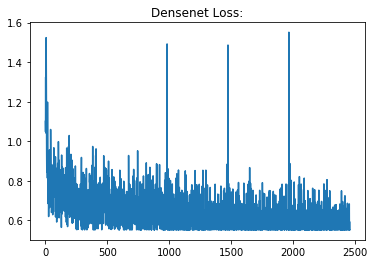

In [43]:
plt.title('Densenet Loss:')
plt.plot(history);

 - ##### Test:

In [44]:
correct, y_pred, y_true = 0, list(), list()

for image, labels in tqdm_notebook(test_feeder):
    
    inputs = Variable(image.cuda()).float()
    outputs = DenseNet_model(inputs)
    
    pred = np.argmax(outputs.data.cpu().numpy())
    true = labels.numpy()[0][0]
    correct += int(pred == true)
    y_pred.append(pred)
    y_true.append(true)
    
print('Accuracy:', correct/len(test_data))

A Jupyter Widget


Accuracy: 0.8287112561174551


 - ##### Accuracy:

In [45]:
print('Accuracy:', correct/len(test_data))

Accuracy: 0.8287112561174551


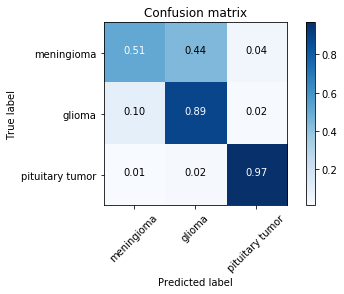

In [46]:
plot_confusion_matrix(cm=confusion_matrix(y_true, y_pred), classes=['meningioma','glioma','pituitary tumor'])

2do: Densenet + augmentation

# CapsNet:

# Comparison:

# Conclusion: